# Foundations of Artificial Intelligence and Machine Learning
## A Program by IIIT-H and TalentSprint
#### To be done in the Lab

The objective of this experiment is to understand RNN.

In this experiment we will use RNN to classify text one character at a time. We will be using shakespeare.txt as our input file to the classifier.

The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations.

##### Keywords

* RNN
* Gated recurrent unit
* Crossentropy
* Adam

##### Expected time to complete the experiment is : 90 min

## 1. Preparing the data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the unidecode package.

To install the package run the following command


** !pip3 install unidecode **

In [3]:
## Importing required packages
import unidecode
import string
import random
import re

In [4]:
all_characters = string.printable
## code to find length of all_characters and storing the value in n_characters
n_characters = len(all_characters)
## code to convert unicode characters into plain ASCII.
file = unidecode.unidecode(open('shakespeare.txt').read())
## code to find length of the file
file_len = len(file)
## printing the length of the file
print('file_len =', file_len)

file_len = 1115393


In [5]:
file[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

As the string is large, we are going to split it into chunks to provide inputs to the RNN using function random_chunk().

In [6]:
## Initializing the length of chunk
chunk_len = 200
## Function to split the string into chunks
def random_chunk():
    ## Initializing the starting index value of the big string 
    start_index = random.randint(0, file_len - chunk_len)
    ## Initializing the ending index of the string 
    end_index = start_index + chunk_len + 1
    ## returning the chunk
    return file[start_index:end_index]

print(random_chunk())

tness: his approach,
So out of circumstance and sudden, tells us
'Tis not a visitation framed, but forced
By need and accident. What train?

Gentleman:
But few,
And those but mean.

LEONTES:
His prince


##  2. Building the model

This model will take as input the character for step $t_{-1}$, and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [7]:
###importing required packages
import torch
import torch.nn as nn
from torch.autograd import Variable

### Creating recurrent neural network
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

## 3. Defining the helper functions

#### Inputs and targets

Each chunk will be turned into a tensor, specifically a LongTensor (used for integer values), by looping through the characters of the string and looking up the index of each character in all_characters.

In [8]:
# Turn string into list of longs
def char_tensor(string):
    ## tensor is a array
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters up to the last, and the target will be all characters from the first. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

#### Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.



In [10]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

## 4. Training the model

To keep track of how long training takes, we have added a time_since(timestamp) function which returns a human readable string

In [13]:
## Importing required packages
import time, math
## function to print amount of time passed
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### The main training function

In [14]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(dim=0))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training

In [15]:
n_epochs = 2000 #Number of epochs
print_every = 50
plot_every = 20
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
## Optimizer
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
## Loss function
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

#In this for loop for every 100th iteration we are printing the time taken, loss and the chunk.
for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 5s (50 2%) 2.6240]
Whed the hern ar nou hat silll rist yhes om herran dat kil sat smis tof
I inin torsllu iq nind ime  ca 

 12s (100 5%) 2.3366]
Whi to the the the pord of hi min:
Whe arilse:
The gufkr nou that pou I wit aithem hie to the the the  

 20s (150 7%) 2.2570]
Whal, ceat ow sar
And mus I mis ond ntand dat thred spear't Cy now! Alf not:
Nor sis a veint:
Cour pim 

 27s (200 10%) 2.2693]
Whith, your and fourt thy peduriand hied, wit prith meng.

NbARD:
Nour that hes,
That,
Where that my s 

 34s (250 12%) 2.0695]
What cave a har, apsin wet in then lair:
Shous the tathat
Fiond engell no chat exgighe weat with tion. 

 41s (300 15%) 2.0416]
Whe deserther
Sel herfor sous a with I heull pir Jow wink of let I hers hat parties the wing this for  

 49s (350 17%) 2.1009]
Wher had the faird hore there lignyo trild
While,
Se to theed
And I the ar.

Frere whele there sent,
O 

 56s (400 20%) 2.0678]
Wherist and ghather' fay aather: scans andord, I nersed;
Whou juse:
The formest your o

#### Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning

Text(0,0.5,'loss')

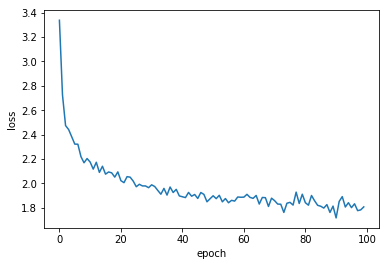

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
plt.xlabel("epoch")
plt.ylabel("loss")

#### Adapting or tuning for prose writing

In the evaluate function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.


We can see the effects of this by adjusting the temperature argument.

print(evaluate('u', 200, temperature=0.4))

Lower temperatures are less varied, choosing only the more probable outputs:

print(evaluate('Th', 200, temperature=0.2))


Higher temperatures more varied, choosing less probable outputs:

print(evaluate('how', 200, temperature=0.5))

### Exercise 1:

Change the number of epochs to 1000. Calculate the time taken and loss.

### Exercise 2:

Change the print every to 50 and plot every to 20. Calculate the time taken and loss and plot the loss graph

In [19]:
print(evaluate('how', 200, temperature=0.7))

how--
This mant your houslents of the be now here,
I king leary, sore the me true
The wo lown your ging of lies one his
And, and I honsee and kide praint whate one the be
Whom fear no strandy, your took

